### Imports

In [20]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

### Constants

In [21]:
base_path = Path("/Users/tusharsingh/Work/Project/tcga-mldl/results/data/data_splits")
plotdir = Path("/Users/tusharsingh/Work/Project/tcga-mldl/results/plots")
split_sets = {
    "5pct_80": base_path / "5pct_80",
    "15pct_80": base_path / "15pct_80",
    "25pct_80": base_path / "25pct_80"
}

### Load function

In [22]:
def load_split_data(split_path):
    split_path = Path(split_path)
    X_train = pd.read_csv(split_path / "X_train.csv", index_col=0)
    X_test = pd.read_csv(split_path / "X_test.csv", index_col=0)
    y_train = pd.read_csv(split_path / "y_train.csv", index_col=0).squeeze()
    y_test = pd.read_csv(split_path / "y_test.csv", index_col=0).squeeze()
    return X_train, X_test, y_train, y_test


### GridSearchCV 

In [23]:
def run_svm_gridsearch(X_train, y_train, X_test, y_test, cv_folds=5):
    svc = SVC()

    param_grid = [
        {'kernel': ['rbf'], 'C': [ 1, 10, 100], 'gamma': ['scale', 'auto',1, 0.1]}
    ]

    grid = GridSearchCV(
        svc,
        param_grid,
        cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42),
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )

    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    return {
        "best_params": grid.best_params_,
        "cv_best_score": grid.best_score_,
        #"test_acc": accuracy_score(y_test, y_pred),
        "report": classification_report(y_test, y_pred, output_dict=True),
        "conf_matrix": confusion_matrix(y_test, y_pred)
    }


### 5-FOLD

In [24]:
results_svm_5fold = []

for name, path in split_sets.items():
    X_train, X_test, y_train, y_test = load_split_data(path)
    out = run_svm_gridsearch(X_train, y_train, X_test, y_test, cv_folds=5)

    results_svm_5fold.append({
        "Split": name,
        "Samples": X_train.shape[0],
        "Features": X_train.shape[1],
        "CV Accuracy": round(out["cv_best_score"], 4),
        #"Test Accuracy": round(out["test_acc"], 4),
        "Best Params": out["best_params"]
    })

results_svm_5f = pd.DataFrame(results_svm_5fold).sort_values("CV Accuracy", ascending=False)
results_svm_5f


,Split,Samples,Features,CV Accuracy,Best Params
2,25pct_80,408,9784,0.7036,"{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}"
1,15pct_80,408,5870,0.6962,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}"
0,5pct_80,408,1956,0.6740,"{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}"


### 10-Fold

In [25]:
results_svm_10fold = []

for name, path in split_sets.items():
    X_train, X_test, y_train, y_test = load_split_data(path)
    out = run_svm_gridsearch(X_train, y_train, X_test, y_test, cv_folds=10)

    results_svm_10fold.append({
        "Split": name,
        "Samples": X_train.shape[0],
        "Features": X_train.shape[1],
        "CV Accuracy": round(out["cv_best_score"], 4),
        #"Test Accuracy": round(out["test_acc"], 4),
        "Best Params": out["best_params"]
    })

results_svm_10f = pd.DataFrame(results_svm_10fold).sort_values("CV Accuracy", ascending=False)
results_svm_10f


,Split,Samples,Features,CV Accuracy,Best Params
1,15pct_80,408,5870,0.7038,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}"
2,25pct_80,408,9784,0.7038,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}"
0,5pct_80,408,1956,0.6742,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}"


In [26]:
# Analyze one split in detail, e.g., "15pct_80"
X_train, X_test, y_train, y_test = load_split_data(split_sets["15pct_80"])
out = run_svm_gridsearch(X_train, y_train, X_test, y_test, cv_folds=10)
# Classification report
pd.DataFrame(out["report"]).T


,precision,recall,f1-score,support
0,0.788462,0.732143,0.759259,56.000000
1,0.700000,0.760870,0.729167,46.000000
accuracy,0.745098,0.745098,0.745098,0.745098
macro avg,0.744231,0.746506,0.744213,102.000000
weighted avg,0.748567,0.745098,0.745688,102.000000


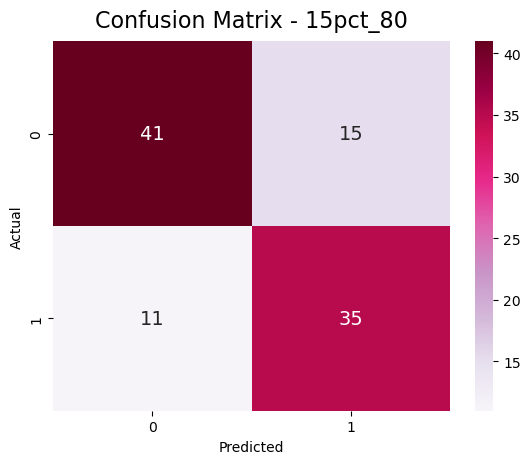

In [27]:
sns.heatmap(out["conf_matrix"], annot=True, fmt='d', cmap="PuRd", cbar=True, annot_kws= {"fontsize":14})
plt.title(f"Confusion Matrix - 15pct_80", fontsize = 16 , pad = 10)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(plotdir/"CF_logistic.png", bbox_inches="tight", dpi=300)
plt.show()


In [28]:
results_svm_5f.to_csv("/Users/tusharsingh/Work/Project/tcga-mldl/results/data/svm_5f_results.csv")
results_svm_10f.to_csv("/Users/tusharsingh/Work/Project/tcga-mldl/results/data/svm_forest_10f_results.csv")